In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
import glob

In [3]:
files = glob.glob("/mnt/data/yanzi/xiaomi_vacuum_as_data_collector/data_parsed_all/*.pickle")
files_png = glob.glob("/mnt/data/yanzi/xiaomi_vacuum_as_data_collector/data_parsed_all/*.png")

In [4]:
def file_info(fname):
    parts = fname.split('/')[-1].split('_')
    date, time, dev, mac, _, pkt_type, _ = parts[:7]
    return date, time, dev, mac, pkt_type

In [5]:
import pickle
import numpy as np

In [6]:
import os
import sys
repo = "/home/gomezp/advloc"
sys.path.append(repo)
from models import create_model
from options.test_options import TestOptions
import torch
from data.rss_dataset import RSSDataset

In [7]:
# hack to avoid passing command-line arguments
sys.argv = ["--seed=666", "--gpu_ids=1",
            "--dataroot=''", "--name=rss_v3_10",
            "--model=rssmap2rssmap", "--input_nc=1",
            "--output_nc=1", "--norm=batch",
            "--dataset_mode=rss", "--num_threads=0",
            "--batch_size=1", "--netG=unet_64",
            "--verbose", "--no_flip", "--serial_batches"]
opt = TestOptions().parse()  # get test options
opt.display_id = -1 # do not use visdom; we will save plots ourselves

dataset = RSSDataset(opt)
model = create_model(opt)

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
             blocked_size: 0                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ''                            	[default: None]
             dataset_mode: rss                           	[default: aligned]
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 1                             	[default: 0]
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 1                             	[default: 3]
                  isTrain: 

In [8]:
def test_single(A_path):
    with open(A_path, 'rb') as f:
        data_A = pickle.load(f)
    if data_A[1] is None:
        return
    
    # Extract ground truth from file
    date, time, dev, mac, pkt_type = file_info(A_path)
    map_A, x, y = data_A[0], *data_A[1]
    loc = np.array([x, y])
    
    # Prepare image as model input
    map_A = torch.tensor(dataset.normalize_data(map_A), dtype=torch.float32)
    map_A = map_A.view((1, map_A.size()[0], -1)).unsqueeze(0)

    tx_loc_np = (loc - 32.) / 64.
    # `normalize_loc` is not correct here: input coords are i [0,64] range, not [-5,5]
    #tx_loc_np = dataset.normalize_loc(loc)
    tx_loc = torch.tensor(tx_loc_np).float()
    tx_pwr_np = dataset.normalize_data(np.array([-34])) # hack; figure this out!
    tx_pwr = torch.tensor(tx_pwr_np).float()
    tx_loc_pwr = torch.cat((tx_loc, tx_pwr))

    # Pack input data
    data = {'A': map_A, 'B': map_A, 'A_paths': A_path, 'B_paths': A_path, 'tx_loc_pwr': tx_loc_pwr}
    
    realA = map_A.squeeze().numpy()
    
    # Forward and extract visuals
    model.set_input(data)
    model.test()
    visuals = model.get_current_visuals()
    visuals_np = {}
    for v in visuals:
        t = visuals[v]
        visuals_np[v] = t.cpu().float().squeeze().numpy()
    
    # Extract transmitter location from latent space
    task_tx_loc = model.latent[:2].cpu().float().squeeze().numpy()
    
    #return realA, realB, visuals_np, tx_loc_np, tx_pwr_np, task_tx_loc
    return realA, visuals_np, loc, task_tx_loc

In [9]:
def l2(x):
    from math import sqrt
    return sqrt(np.sum(x**2))
def l1(x):
    return np.sum(abs(x))
def denorm_rss(x):
    return ((x + 1) / 2) * (dataset.max_rss - dataset.min_rss) + dataset.min_rss

def test(epoch):
    opt.epoch = epoch
    opt.load_iter = 0
    from IPython.utils import io
    with io.capture_output() as captured:
        model.setup(opt)
    
    loc_diffs = []
    rss_diffs = []
    
    for idx, fname in enumerate(files):
        res = test_single(fname)
        if res is None:
            continue
        real_A, visuals, loc, task_loc = res
        
        # compute localization error
        loc = (loc - 32.) / 64.
        loc_diffs.append(l2(loc[::-1] - task_loc))
        
        # compute rss error
        fake_B = visuals['fake_B']
        scaled_fake_B = denorm_rss(fake_B)
        scaled_real_A = denorm_rss(real_A)
        rss_diffs.append(l1(scaled_real_A - scaled_fake_B) / real_A.size)
        

    #loc_diffs = np.array(loc_diffs)
    #rss_diffs = np.array(rss_diffs)
    #return [[ loc_diffs.mean(), loc_diffs.std(), loc_diffs.min(), loc_diffs.max() ],
    #    [ rss_diffs.mean(), rss_diffs.std(), rss_diffs.min(), rss_diffs.max() ]]
    return [loc_diffs, rss_diffs]

loading the model from ./checkpoints/rss_v3_10/200_net_G.pth
---------- Networks initialized -------------
DataParallel(
  (module): UnetGenerator(
    (model): UnetSkipConnectionBlock(
      (model): Sequential(
        (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): UnetSkipConnectionBlock(
          (model): Sequential(
            (0): LeakyReLU(negative_slope=0.2, inplace)
            (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
            (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): UnetSkipConnectionBlock(
              (model): Sequential(
                (0): LeakyReLU(negative_slope=0.2, inplace)
                (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (3): UnetSkipConnectio

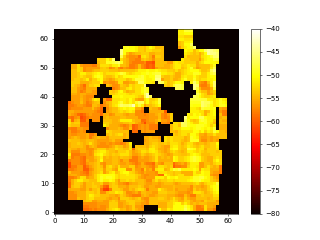

In [10]:
# Testing...
# ---------------------
opt.epoch = 200
opt.load_iter = 0
model.setup(opt)
idx = -16

_, _, loc, task_loc = test_single(files[idx])
print((loc - 32.) / 64., "\n", task_loc)

from IPython.display import Image
Image(filename=files_png[idx]) 

# Localization statistics
---------

In [19]:
%%time
test_epoches = range(0,201,5)

import time
# create results path
tstamp = int(time.time())
out_dir = "{}/results/{}_real_out_{}".format(repo, opt.name, tstamp)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

from datetime import datetime
print("Started at", str(datetime.now()))
print("Testing on epoch ", end="")

diffs = []
for epoch in test_epoches:
    print("{}, ".format(epoch), end="")
    diffs.append(test(epoch))
print("done!")
print("Finished at", str(datetime.now()))

Started at 2019-06-28 14:35:20.883029
Testing on epoch 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, done!
Finished at 2019-06-28 14:36:04.828929
CPU times: user 40.2 s, sys: 3.76 s, total: 44 s
Wall time: 43.9 s


## (1) Plot localization error

mean, min, max, std : epoch 200
0.558103907725305 0.032439144919521386 1.2519192768212744 0.2694009807063313


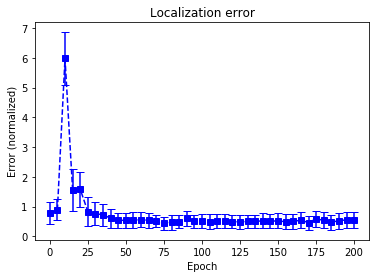

In [35]:
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Error (normalized)")
plt.title("Localization error")

test_epoches = list(test_epoches)
diffs = np.array(diffs)
loc = diffs[:,0]
rss = diffs[:,1]

# epoch-wise mean and stdev
loc_errs = [ e.mean() for e in loc ]
loc_stds = [ e.std() for e in loc ]
plt.errorbar(test_epoches, loc_errs, loc_stds, marker="s", linestyle="--", color="blue", capsize=4)

plt.savefig("{}/loc_error.pdf".format(out_dir))

loc_errs = np.array(loc_errs)
print("mean, min, max, std : epoch 200")
print(loc[-1].mean(), loc[-1].min(), loc[-1].max(), loc[-1].std())

## (2) Plot RSS error

mean, min, max, std
6.834475692608013 3.8437600135803223 12.36960220336914 2.010116282086934


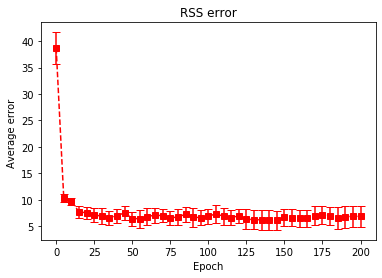

In [34]:
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Average error ")
plt.title("RSS error")

rss_errs = [ e.mean() for e in rss ]
rss_stds = [ e.std() for e in rss ]
plt.errorbar(test_epoches, rss_errs, rss_stds, marker="s", linestyle="--", color="red", capsize=4)

plt.savefig("{}/rss_error.pdf".format(out_dir))

print("mean, min, max, std : epoch 200")
rss_errs = np.array(rss_errs)
print(rss[-1].mean(), rss[-1].min(), rss[-1].max(), rss[-1].std())

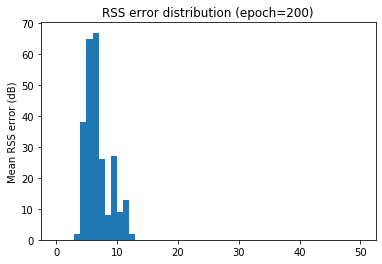

In [24]:
# Explore epoch-wise distributions

plt.figure()
nepochs = len(rss)
for i in range(0,nepochs):
    plt.hist(rss[i], range=[0.0,50.0], bins=50)
    epoch = int(i * (200 / (nepochs - (nepochs % 2))))
    plt.title("RSS error distribution (epoch={})".format(epoch))
    plt.ylabel("Mean RSS error (dB)")
    plt.savefig("{}/rss_dist_epoch{}.pdf".format(out_dir, epoch))
    plt.show()
    time.sleep(1)
    from IPython.display import clear_output
    clear_output(wait=True)

## (3) Save raw data to JSON

In [25]:
import json
# Hack to serialize numpy arrays
class NPEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [26]:
import time
with open("{}/raw.json".format(out_dir), "w") as f:
    json.dump(diffs, f, cls=NPEncoder)